# Spectrogram을 사용한 분류
## 1. 데이터 전처리
### 1-1. 데이터셋 살펴보기

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [2]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  14715
Wave data shape :  (8000,)
label :  ['right']


### 1-2. Label data 처리

In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# unknown, silence label 추가
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

# {단어:인덱스}로 라벨에 index 부여
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
# 텍스트 label을 인덱스 형태로 변환
temp = []
for v in speech_data["label_vals"][:30000]:  # 30000개로 제한
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

### 1-3. Spectrogram으로 변환

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


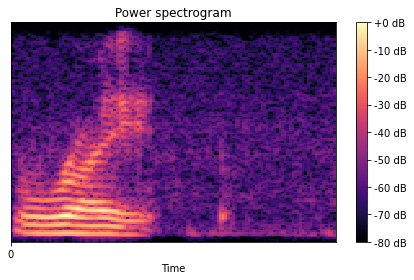

In [7]:
import librosa.display
from matplotlib import pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [8]:
# wav 데이터를 spectrogram 형태로 변환
spec_temp = []
for v in speech_data["wav_vals"][:30000]:  # 30000개로 제한
    spec_temp.append(wav2spec(v))
    
spec_data = np.array(spec_temp)
spec_data.shape

(30000, 130, 126)

### 1-4. Train/Test 데이터 분리

In [9]:
from sklearn.model_selection import train_test_split

# train data와 test data 분리 (test_size 조절 가능)
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
# print(train_wav)

# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])

In [10]:
# 나눠진 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (27000, 130, 126)
train labels :  (27000,)
test data :  (3000, 130, 126)
test labels :  (3000,)


### 1-5. Hyper-parameters setting

In [11]:
# 하이퍼파라미터 설정
batch_size = 32
max_epochs = 10

# 모델 체크포인트 저장을 위한 save point 경로 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'
checkpoint_dir

'/home/ssac21/aiffel/speech_recognition/models/wav'

## 1-6. Data setting

In [12]:
# map 함수에 넘겨줄 데이터 전처리 함수 작성
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [13]:
# tf.data.Dataset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


In [14]:
# 이전에 사용했던 메모리 버퍼 비우기
del speech_data
del spec_data

## 2. Wave classification 모델 구현
### 2-1. Model 구성

In [15]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

### 2-2. Loss

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 2-3. Training

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [18]:
# 30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
836/843 [============================>.] - ETA: 0s - loss: 1.4849 - accuracy: 0.4812
Epoch 00001: val_loss improved from inf to 1.01864, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
843/843 [==============================] - 6s 8ms/step - loss: 1.4807 - accuracy: 0.4827 - val_loss: 1.0186 - val_accuracy: 0.6421
Epoch 2/10
838/843 [============================>.] - ETA: 0s - loss: 0.7834 - accuracy: 0.7260
Epoch 00002: val_loss improved from 1.01864 to 0.61843, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.7822 - accuracy: 0.7265 - val_loss: 0.6184 - val_accuracy: 0.7910
Epoch 3/10
841/843 [============================>.] - ETA: 0s - loss: 0.5018 - accuracy: 0.8297
Epoch 00003: val_loss improved from 0.61843 to 0.53309, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.5016 - accuracy: 0.8298

### 2-4. 학습 결과 시각화

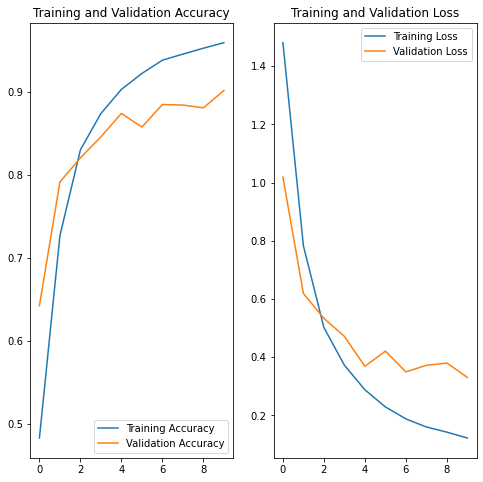

In [19]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2-5. Evaluation

In [20]:
# checkpoint callback 함수가 저장한 weight 불러오기
model_wav.load_weights(checkpoint_dir)

# Test data로 모델의 예측값과 실제값의 일치 정도 확인
results = model_wav.evaluate(test_dataset)

94/94 [==============================] - 15s 164ms/step - loss: 0.3299 - accuracy: 0.9013


In [21]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.330
accuracy value: 90.1333%


### 2-6. Model Test

In [22]:
# Test data를 랜덤으로 골라 직접 들어보고 모델의 예측이 맞는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate=8000)

label :  go


In [23]:
# 위 테스트셋의 라벨과 모델의 실제 prediction 결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: go(Correct!)


## 3. Skip-Connection model 구현
### 3-1. Model 구성

In [24]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

### 3-2. Loss

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 3-3. Training

In [26]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [27]:
# 30분 내외 소요 (메모리 사용량 주의)
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
841/843 [============================>.] - ETA: 0s - loss: 1.6294 - accuracy: 0.4310
Epoch 00001: val_loss improved from inf to 1.11574, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 1.6282 - accuracy: 0.4314 - val_loss: 1.1157 - val_accuracy: 0.6122
Epoch 2/10
841/843 [============================>.] - ETA: 0s - loss: 0.9310 - accuracy: 0.6733
Epoch 00002: val_loss improved from 1.11574 to 0.79480, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 0.9304 - accuracy: 0.6734 - val_loss: 0.7948 - val_accuracy: 0.7285
Epoch 3/10
841/843 [============================>.] - ETA: 0s - loss: 0.6110 - accuracy: 0.7932
Epoch 00003: val_loss improved from 0.79480 to 0.52948, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 0.6106 - a

### 3-4. 학습 결과 시각화

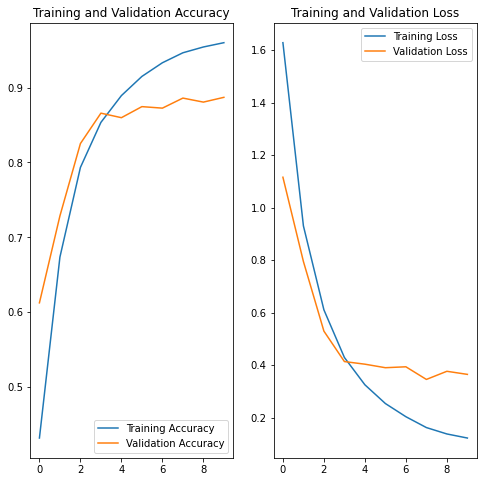

In [28]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3-5. Evaluation

In [29]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

94/94 [==============================] - 4s 42ms/step - loss: 0.3456 - accuracy: 0.8867
loss value: 0.346
accuracy value: 88.6667%


### 3-6. Modet Test

In [30]:
# Test
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate=8000)

label :  no


In [31]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: no(Correct!)


# 프로젝트 정리
- 메모리 과부하 때문인지 전체 데이터를 사용하다 보면 커널이 계속 다운되어 입력 데이터 개수를 30000개로 제한하였다.
- 2차원의 Spectrogram 데이터를 사용하다 보니 shape을 어떻게 설정해야 할지 헷갈렸다. 1차원 wave 데이터일 때는 sampling rate인 8000을 기준으로 reshape 했는데, Spectrogram의 shape은 (130, 126)이었다. 모델의 input shape를 이와 동일하게 설정하니 제대로 작동하긴 했다. 하지만 테스트 단계에서 `ipd.Audio`로 음성으로 되돌리는 것은 되지 않아 해결 방법이 궁금하다.
- 기본 모델과 Skip-connection 모델 모두 정확도는 약 90% 내외로 비슷했다. 몇 번 실행해본 결과, 두 모델의 정확도가 90% 근처에서 엎치락뒤치락했다.
